<a id="section_CART"></a> 
## Workshop Final DS Digital House

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
pd.set_option('display.max_columns', None)
import missingno as msno
#from dataprep.eda import plot, plot_correlation, create_report, plot_missing

%matplotlib inline

# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

## Importando os dados

In [2]:
# importando bases de treino e teste
df_test = pd.read_csv(r"../DataSet/test.csv", low_memory = False)
df_train = pd.read_csv(r"../DataSet/train.csv", low_memory = False)

## Agrupando os datasets para limpar os dados

In [3]:
# # incluindo colunas para sperar os dados da mesma maneira que estavam originalmente
# df_train['test'] = 0
# df_test['test'] = 1

# # incluindo coluna de score com nan nos dados de teste
# df_test['Credit_Score'] = np.nan

In [4]:
# concatenando os datasets ja que eles tem as mesmas colunas

df_total = pd.concat([df_train, df_test], ignore_index = True)
df_orig = df_total.copy()

In [5]:
print('dados de treino: ', df_train.shape)
print('dados de teste: ', df_test.shape)
print('todos os dados agrupados: ', df_total.shape)

dados de treino:  (100000, 28)
dados de teste:  (50000, 27)
todos os dados agrupados:  (150000, 28)


## Colunas dataset:

* ID - Identificador de entrada
* Customer_ID - ID cliente
* Month - Mês do ano
* Name - nome do cliente
* Age - Idade Cliente
* SSN - Social Security Number (CPF no Brasil)
* Occupation - Ocupação do cliente
* Annual_Income - renda anual
* Monthly_Inhand_Salary - Salario mensal do cliente
* Num_Bank_Accounts - quantidade de contas em bancos
* Num_Credit_Card - quantidade de cartões de crédito
* Interest_Rate - taxa de juros cartão de crédito
* Num_of_Loan - Quantidade de empréstimos feitos no banco
* Type_of_Loan - tipo de empréstimo feito pelo cliente
* Delay_from_due_date - qtd. de dias de atraso pagamento cartão
* Num_of_Delayed_Payment - Média de pagamentos atrasado pelo cliente
* Changed_Credit_Limit - Variação percentual de limite do cartão de crédito
* Num_Credit_Inquiries - Quantidade de "cobranças" no cartão
* Credit_Mix - mix de crédito do cliente
* Outstanding_Debt - restante à ser pago da dívida
* Credit_Utilization_Ratio - Taxa de utlização do cartão de crédito
* Credit_History_Age - Tempo de histórico de crédito do cliente
* Payment_of_Min_Amount - Pagamento minimo
* Total_EMI_per_month - Pagamento fixo em dolares por mes
* Amount_invested_monthly - Quantidade de dinheiro investido pelo cliente mensalmente
* Payment_Behaviour - Comportamento de pagamento cliente
* Monthly_Balance - Saldo Mensal Cliente
* Credit_Score - Target, Pontuação de uso de crédito
* test - coluna utilizada para separar o dataset nos dados de treino e teste

In [6]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        150000 non-null  object 
 1   Customer_ID               150000 non-null  object 
 2   Month                     150000 non-null  object 
 3   Name                      135000 non-null  object 
 4   Age                       150000 non-null  object 
 5   SSN                       150000 non-null  object 
 6   Occupation                150000 non-null  object 
 7   Annual_Income             150000 non-null  object 
 8   Monthly_Inhand_Salary     127500 non-null  float64
 9   Num_Bank_Accounts         150000 non-null  int64  
 10  Num_Credit_Card           150000 non-null  int64  
 11  Interest_Rate             150000 non-null  int64  
 12  Num_of_Loan               150000 non-null  object 
 13  Type_of_Loan              132888 non-null  o

## Checando os principais valores de algumas colunas

In [7]:
colunas = df_total.columns

for coluna in colunas:
    print('Variavel: ', coluna)
    print(20*'-')
    print(df_total[coluna].value_counts(dropna=False))

Variavel:  ID
--------------------
0xdb83     1
0x2ad3     1
0x3610     1
0x206db    1
0x8bfc     1
          ..
0x13869    1
0x1c8e1    1
0x16c51    1
0xce05     1
0x1377f    1
Name: ID, Length: 150000, dtype: int64
Variavel:  Customer_ID
--------------------
CUS_0xa98a    12
CUS_0x2869    12
CUS_0x8fa9    12
CUS_0x510b    12
CUS_0xb4c1    12
              ..
CUS_0xbc99    12
CUS_0xd7d     12
CUS_0x8225    12
CUS_0x65fe    12
CUS_0xac7c    12
Name: Customer_ID, Length: 12500, dtype: int64
Variavel:  Month
--------------------
March        12500
November     12500
April        12500
June         12500
August       12500
May          12500
January      12500
July         12500
September    12500
February     12500
December     12500
October      12500
Name: Month, dtype: int64
Variavel:  Name
--------------------
NaN                   15000
Stevex                   66
Langep                   65
Jessicad                 59
Raymondr                 58
                      ...  
Fabir   

### Observações

1. Colunas numéricas com "_" ok
    * Age,
    * Annual_Income,
    * Monthly_Inhand_Salary,
    * Num_Bank_Accounts,
    * Num_Credit_Card,
    * Interest_Rate
    * Num_of_Loan
    * Delay_from_due_date
    * Num_of_Delayed_Payment
    * Changed_Credit_Limit
    * Num_Credit_Inquiries
    * Outstanding_Debt
    * Credit_Utilization_Ratio
    * Total_EMI_per_month
    * Amount_invested_monthly
    * Monthly_Balance
2. SSN #F%$D@*&8 ok
3. Occupation _______ ok
4. Type_of_Loan - transformar em lista e indexar
5. Changed_Credit_Limit "_" -> NaN ok
6. Credit_Mix "_" -> NaN ok
7. Credit_History_Age Transformar em qtd. Meses
8. Payment_of_Min_Amount "NM" -> NaN ok
9. Payment_Behaviour "!@9#%8" -> NaN e transformar dado ok

## Ajustando os campos númericos que estão definidos como string por terem underlines em alguns registros

In [8]:
# Campos númericos que estão como string - retirar underline dos numeros

colunas_ul = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
              'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']
for row in colunas_ul:
    df_total[row] = df_total[row].str.replace(r'_+', '')

<ipython-input-8-307ac66e0f28>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_total[row] = df_total[row].str.replace(r'_+', '')


## Data Wrangling

* Limpeza nos campos com dados inconsistentes

In [9]:
# Removendo coluna ID, completamente inútil para a análise
df_total.drop(['ID'], axis = 1, inplace = True)

# removendo caracter estranho do SSN
df_total['SSN'].replace('#F%$D@*&8', np.NaN, inplace=True)

# removendo os underlines e colocando NaN na coluna Occupation
df_total['Occupation'].replace('_______', np.NaN, inplace=True)

df_total['Changed_Credit_Limit'].replace(['_', ''], np.NaN, inplace=True)

df_total['Credit_Mix'].replace('_', np.NaN, inplace=True)

df_total['Payment_of_Min_Amount'].replace('NM', np.NaN, inplace=True)

df_total['Payment_Behaviour'].replace('!@9#%8', np.NaN, inplace=True)

### Convertendo campo de credit history para qtd. Meses
* 1 year = 12 months

In [10]:
# convertendo Credit_History_Age em quantidade de meses
def converter_mes(x):
    if pd.notnull(x):
        ano = int(x.split(' ')[0])
        mes = int(x.split(' ')[3])
        return (ano*12)+mes
    else:
        return x

df_total['Credit_History_age'] = df_total['Credit_History_Age'].apply(lambda x: converter_mes(x)).astype(float)

### Removendo 'and' no preenchimento do campo

In [11]:
df_total['Type_of_Loan_ajustado'] = df_total['Type_of_Loan'].replace("[abc]* and ", " ", regex=True)

### Conversão de dados

In [12]:
#criando dicionario e convertendo os dados

dicionario_conversao = {
    'Age': int,
    'Num_Bank_Accounts': int,
    'Num_Credit_Card': int,
    'Num_of_Loan': int,
    'Num_of_Delayed_Payment': int,
    'Annual_Income' : float,
    'Monthly_Inhand_Salary' : float,
    'Interest_Rate' : float,
    'Delay_from_due_date' : float,
    'Changed_Credit_Limit' : float,
    'Num_Credit_Inquiries' : float,
    'Outstanding_Debt' : float,
    'Credit_Utilization_Ratio' : float,
    'Changed_Credit_Limit' : float,
    'Amount_invested_monthly' : float,
    'Total_EMI_per_month' : float,
    'Num_of_Delayed_Payment' : float,
    'Monthly_Balance' : float,
    # 'ID' : object,
    'Customer_ID' : object,
    'Name' : object,
    'Month' : object,
    'SSN' : object,
    'Type_of_Loan' : object,
    'Occupation' : object,
    'Credit_Mix' : object,
    'Payment_of_Min_Amount' : object,
    'Payment_Behaviour' : object
    # 'test' : object
    }
# aplicando as type para variaveis

df_total = df_total.astype(dicionario_conversao)

In [13]:
# convertendo mes para encoding

import datetime

df_total['Month'] = df_total['Month'].apply(lambda x: datetime.datetime.strptime(x, '%B').month)

### Visualização dos dados pré limpeza

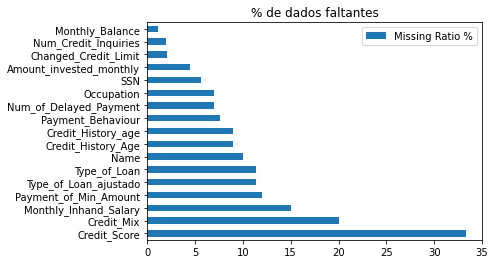

In [14]:
# Esta função define a quantidade % de dados faltantes
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.title("% de dados faltantes")
        plt.show()
    else:
        print('No NAs found')
        
plot_nas(df_total)

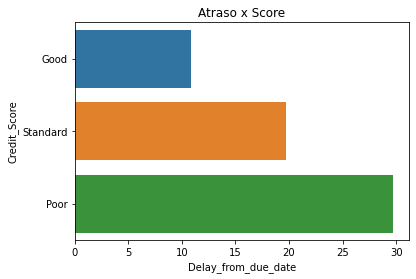

In [15]:
ordem1 = df_total.groupby(['Credit_Score'])['Delay_from_due_date'].mean().sort_values().index

sns.barplot(data = df_total,
            x='Delay_from_due_date',
            y='Credit_Score',
            ci = None,
            order = ordem1)
plt.title('Atraso x Score')
plt.show()

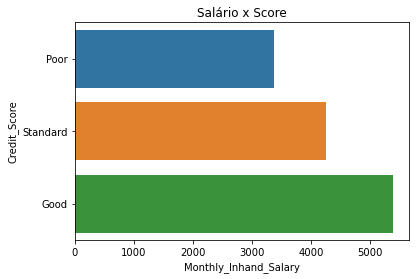

In [16]:
ordem2 = df_total.groupby(['Credit_Score'])['Monthly_Inhand_Salary'].mean().sort_values().index

sns.barplot(data = df_total,
            x='Monthly_Inhand_Salary',
            y='Credit_Score',
            ci = None,
            order = ordem2)

plt.title('Salário x Score')
plt.show()

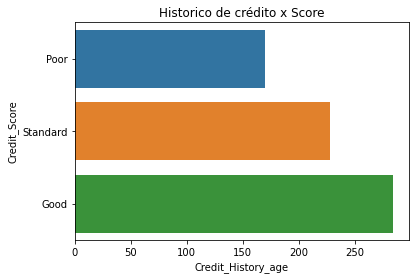

In [17]:
ordem2 = df_total.groupby(['Credit_Score'])['Credit_History_age'].mean().sort_values().index

sns.barplot(data = df_total,
            x='Credit_History_age',
            y='Credit_Score',
            ci = None,
            order = ordem2)

plt.title('Historico de crédito x Score')
plt.show()

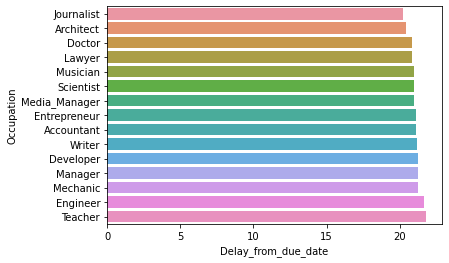

In [18]:
ordem1 = df_total.groupby(['Occupation'])['Delay_from_due_date'].mean().sort_values().index

sns.barplot(data = df_total,
            x='Delay_from_due_date',
            y='Occupation',
            ci = None,
            order = ordem1)
plt.show()

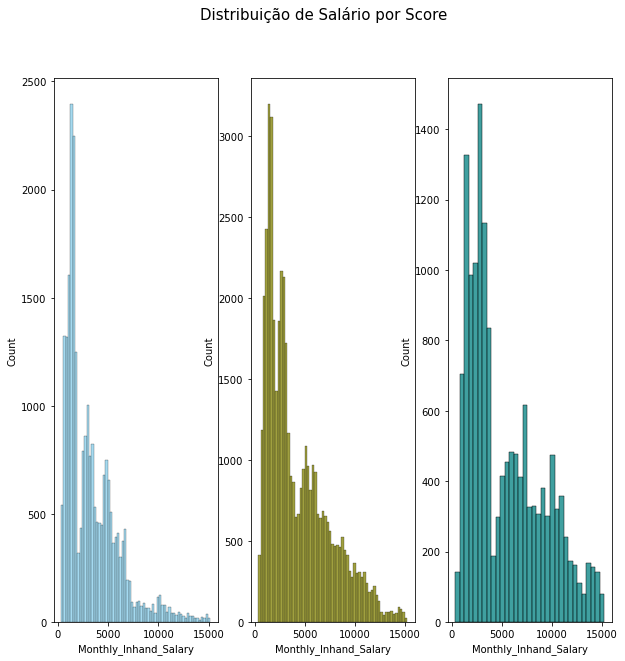

In [19]:
fig, axs = plt.subplots(1, 3, figsize = (10,10))

sns.histplot(data = df_total[df_total['Credit_Score'] == 'Poor'], x = 'Monthly_Inhand_Salary', ax = axs[0], color = 'skyblue')
sns.histplot(data = df_total[df_total['Credit_Score'] == 'Standard'], x = 'Monthly_Inhand_Salary', ax = axs[1], color = 'olive')
sns.histplot(data = df_total[df_total['Credit_Score'] == 'Good'], x = 'Monthly_Inhand_Salary', ax = axs[2], color = 'teal')

fig.suptitle('Distribuição de Salário por Score', size = 15)
plt.show()


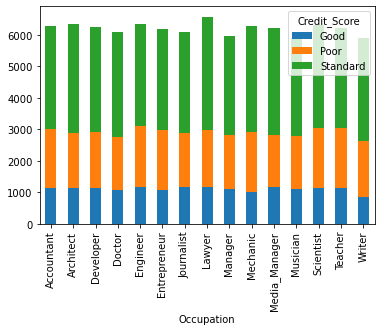

In [20]:
df_plot = df_total.groupby(['Occupation', 'Credit_Score']).size().reset_index().pivot(columns='Credit_Score', index='Occupation', values=0)

df_plot.plot(kind='bar', stacked=True)
plt.show()

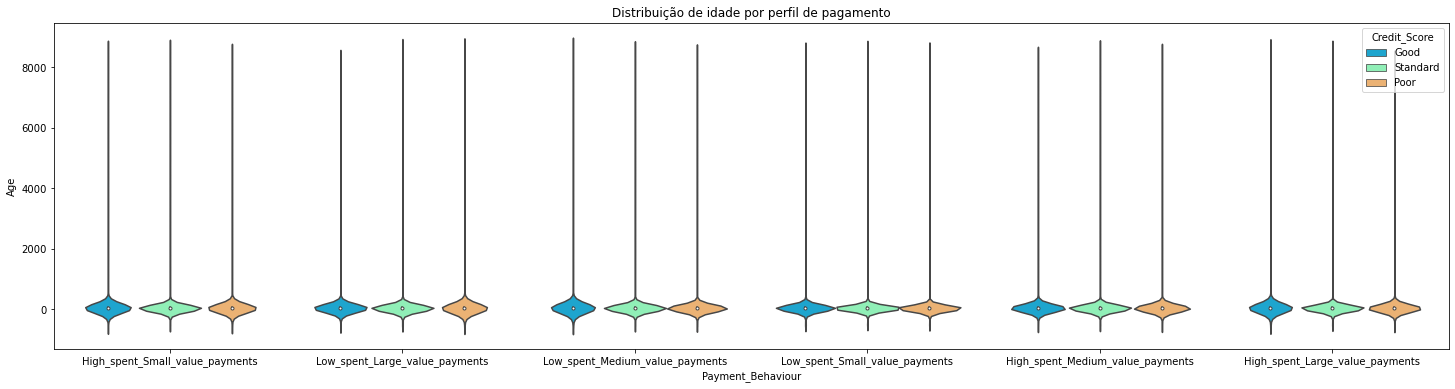

In [21]:
plt.figure(figsize=(25,6))
sns.violinplot(x='Payment_Behaviour',y='Age',data=df_total, hue='Credit_Score', palette='rainbow')
plt.title("Distribuição de idade por perfil de pagamento")
plt.show()

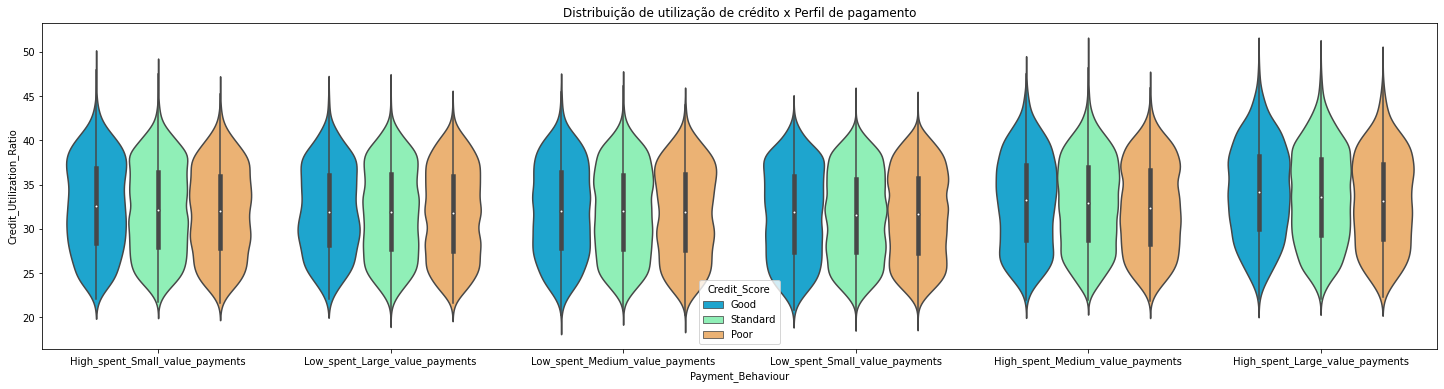

In [22]:
plt.figure(figsize=(25,6))
sns.violinplot(x='Payment_Behaviour',y='Credit_Utilization_Ratio',data=df_total, hue='Credit_Score', palette='rainbow')
plt.title("Distribuição de utilização de crédito x Perfil de pagamento")
plt.show()

<Figure size 4248x72 with 0 Axes>

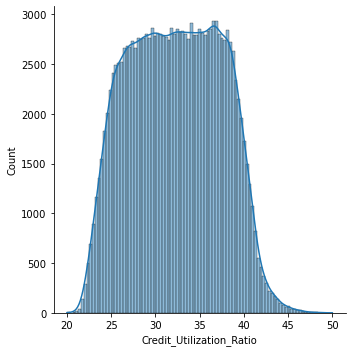

In [23]:
plt.figure(figsize=(59,1))
sns.displot(data=df_total, x="Credit_Utilization_Ratio", kde=True)

<Figure size 12960x432 with 0 Axes>

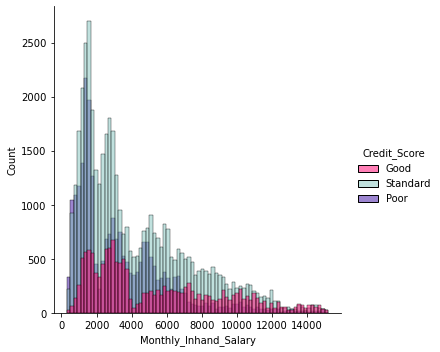

<Figure size 12960x432 with 0 Axes>

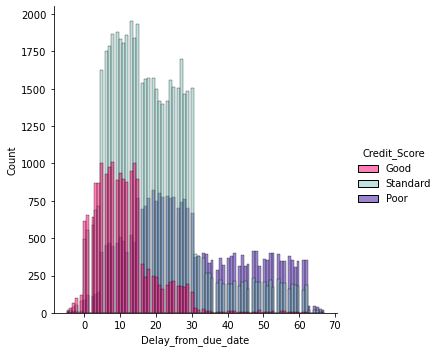

<Figure size 12960x432 with 0 Axes>

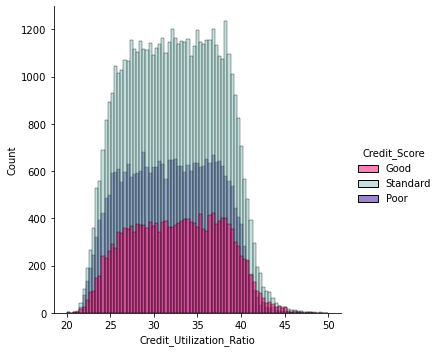

In [24]:
numCols = ['Monthly_Inhand_Salary', 'Delay_from_due_date', 'Credit_Utilization_Ratio']

for col in numCols:
    plt.figure(figsize=(180,6))
    sns.displot(x=col,data=df_total, hue='Credit_Score', palette=["#ff006e", "#83c5be", "#3a0ca3"])
    plt.show()

In [25]:
#dropando na

df_nonull = df_total.dropna()

# pegando indices

# df2 = df_nonull.groupby(["Customer_ID"])["Month"].nlargest(1)

# list comprehension para juntar os índices

# indice_final = [i[1] for i in df2.index.values]

# aplicando máscara, pegando somente linha do último mês de cada usuário

# df_nonull_uniqueCID = df_total.loc[indice_final]
df_nonull_uniqueCID = df_nonull.copy()

### Criando função para ver o percentual de dados faltantes no dataset

### Concentração por tipo de ocupação

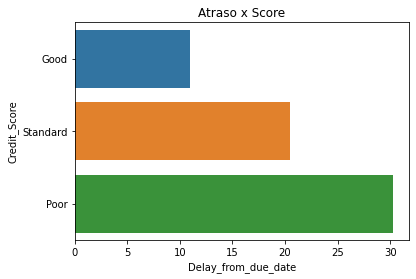

In [26]:
ordem1 = df_nonull_uniqueCID.groupby(['Credit_Score'])['Delay_from_due_date'].mean().sort_values().index

sns.barplot(data = df_nonull_uniqueCID,
            x='Delay_from_due_date',
            y='Credit_Score',
            ci = None,
            order = ordem1)
plt.title('Atraso x Score')
plt.show()

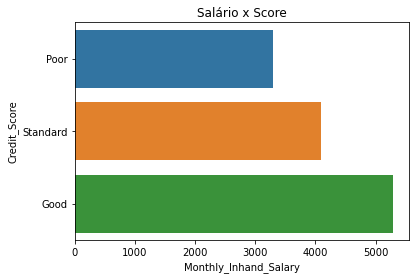

In [27]:
ordem2 = df_nonull_uniqueCID.groupby(['Credit_Score'])['Monthly_Inhand_Salary'].mean().sort_values().index

sns.barplot(data = df_nonull_uniqueCID,
            x='Monthly_Inhand_Salary',
            y='Credit_Score',
            ci = None,
            order = ordem2)

plt.title('Salário x Score')
plt.show()

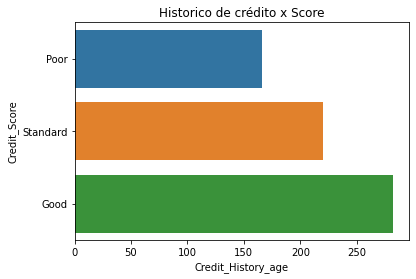

In [28]:
ordem2 = df_nonull_uniqueCID.groupby(['Credit_Score'])['Credit_History_age'].mean().sort_values().index

sns.barplot(data = df_nonull_uniqueCID,
            x='Credit_History_age',
            y='Credit_Score',
            ci = None,
            order = ordem2)

plt.title('Historico de crédito x Score')
plt.show()

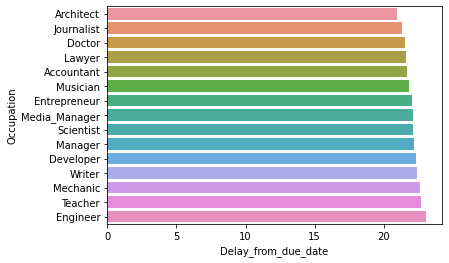

In [29]:
ordem1 = df_nonull_uniqueCID.groupby(['Occupation'])['Delay_from_due_date'].mean().sort_values().index

sns.barplot(data = df_nonull_uniqueCID,
            x='Delay_from_due_date',
            y='Occupation',
            ci = None,
            order = ordem1)
plt.show()

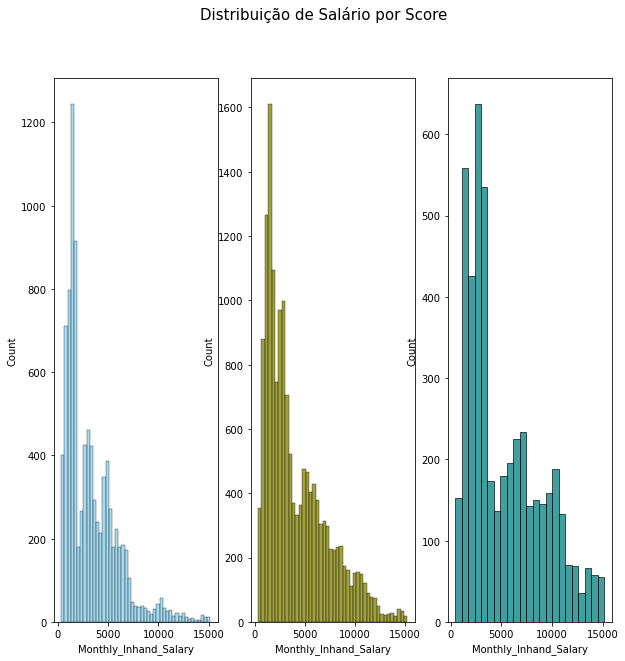

In [30]:
fig, axs = plt.subplots(1, 3, figsize = (10,10))

sns.histplot(data = df_nonull_uniqueCID[df_nonull_uniqueCID['Credit_Score'] == 'Poor'], x = 'Monthly_Inhand_Salary', ax = axs[0], color = 'skyblue')
sns.histplot(data = df_nonull_uniqueCID[df_nonull_uniqueCID['Credit_Score'] == 'Standard'], x = 'Monthly_Inhand_Salary', ax = axs[1], color = 'olive')
sns.histplot(data = df_nonull_uniqueCID[df_nonull_uniqueCID['Credit_Score'] == 'Good'], x = 'Monthly_Inhand_Salary', ax = axs[2], color = 'teal')

fig.suptitle('Distribuição de Salário por Score', size = 15)
plt.show()


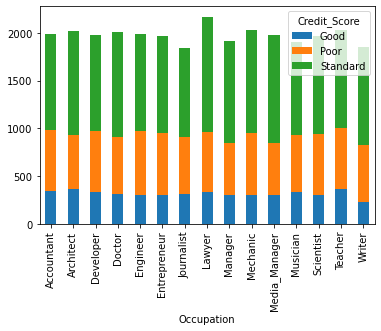

In [31]:
df_plot = df_nonull_uniqueCID.groupby(['Occupation', 'Credit_Score']).size().reset_index().pivot(columns='Credit_Score', index='Occupation', values=0)

df_plot.plot(kind='bar', stacked=True)
plt.show()

In [32]:
"""
numCols = df_total.select_dtypes([np.number]).columns

for col in numCols:
    fig, ax = plt.subplots(1, 2, figsize = (8,8))
    sns.boxplot(data=df_total, y=col, x = 'Credit_Score', ax=ax[0]) #color = ['#f5190a', '#1e9e19', '#dede16'])
    #sns.scatterplot(data=df_total,x = 'Credit_Score', y = s = 100, y=col, ax=ax[1], color ='#ee1199')
    plt.show()
"""

"\nnumCols = df_total.select_dtypes([np.number]).columns\n\nfor col in numCols:\n    fig, ax = plt.subplots(1, 2, figsize = (8,8))\n    sns.boxplot(data=df_total, y=col, x = 'Credit_Score', ax=ax[0]) #color = ['#f5190a', '#1e9e19', '#dede16'])\n    #sns.scatterplot(data=df_total,x = 'Credit_Score', y = s = 100, y=col, ax=ax[1], color ='#ee1199')\n    plt.show()\n"

<AxesSubplot:>

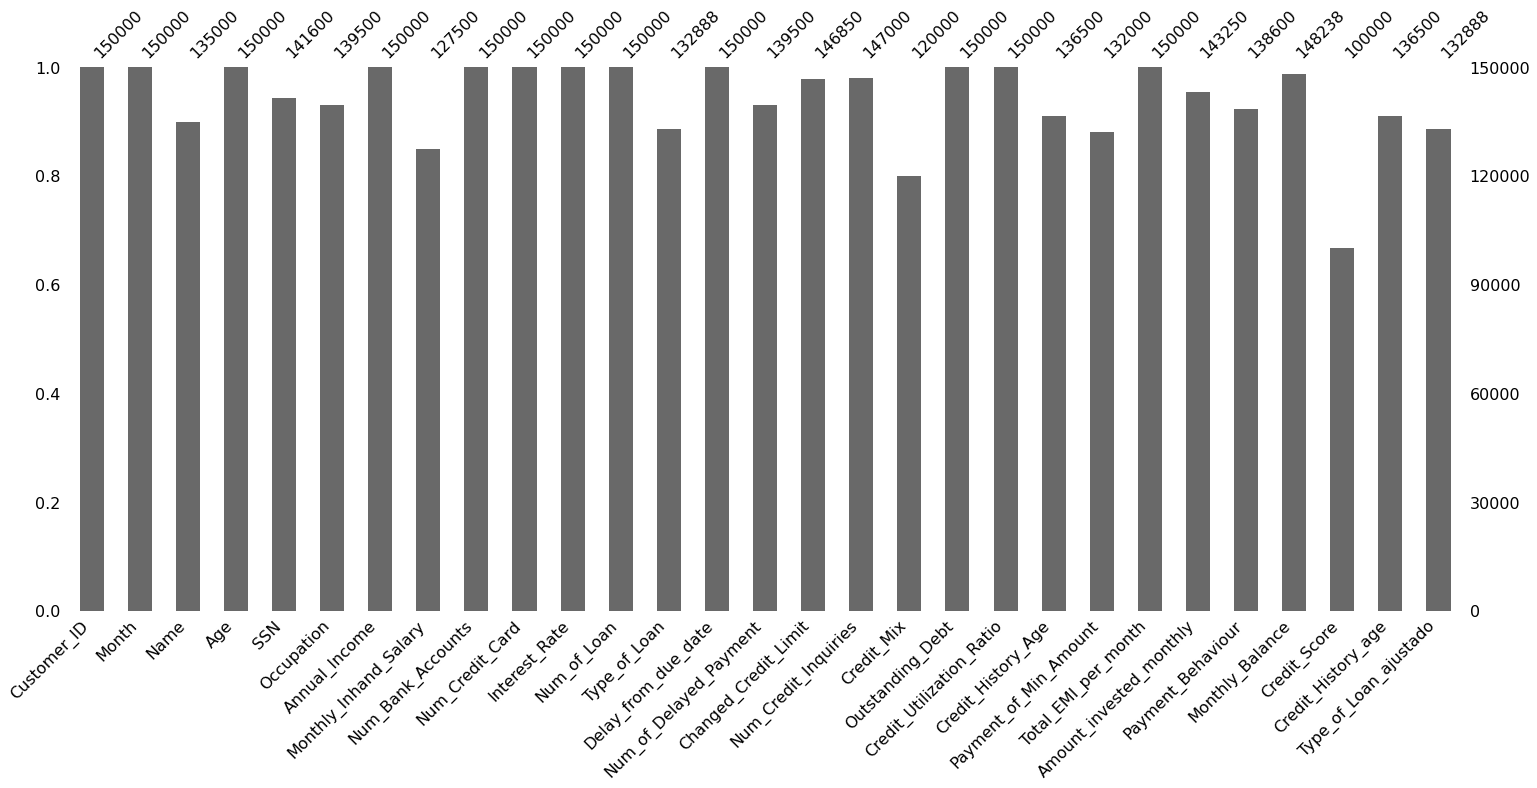

In [33]:
msno.bar(df_total)

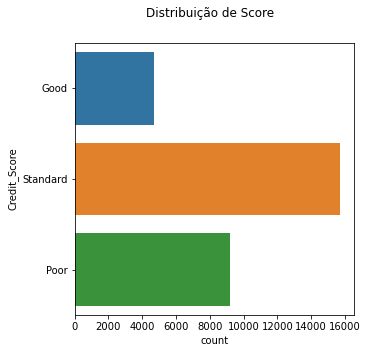

In [34]:
label = df_total.Credit_Score.value_counts().index
label_count = df_nonull_uniqueCID.Credit_Score.value_counts().values
plt.figure(figsize=(5,5))
sns.countplot(data=df_nonull_uniqueCID, y='Credit_Score')
plt.suptitle("Distribuição de Score")
plt.show()

In [35]:
#sns.factorplot('Credit_Score', col = 'Occupation', data = df_total, kind = 'count', col_wrap = 4)

In [36]:
#plot(df_total,'Occupation','Credit_Score')

In [37]:
#plot(df_total,'Age','Credit_Score')

In [38]:
#plt.figure(figsize=(17,8))
#sns.heatmap(df_total.corr(),annot=True,cmap='viridis')

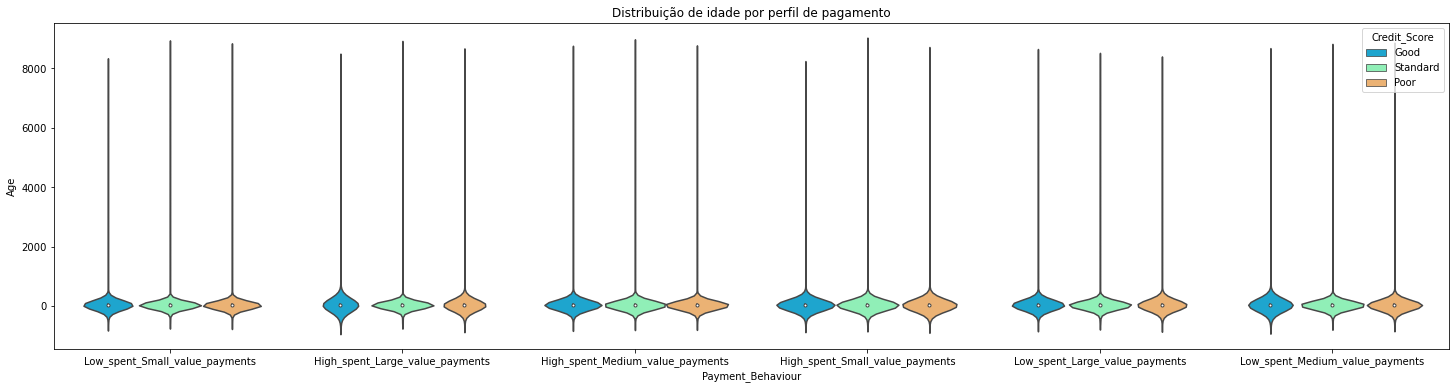

In [39]:
plt.figure(figsize=(25,6))
sns.violinplot(x='Payment_Behaviour',y='Age',data=df_nonull_uniqueCID, hue='Credit_Score', palette='rainbow')
plt.title("Distribuição de idade por perfil de pagamento")
plt.show()

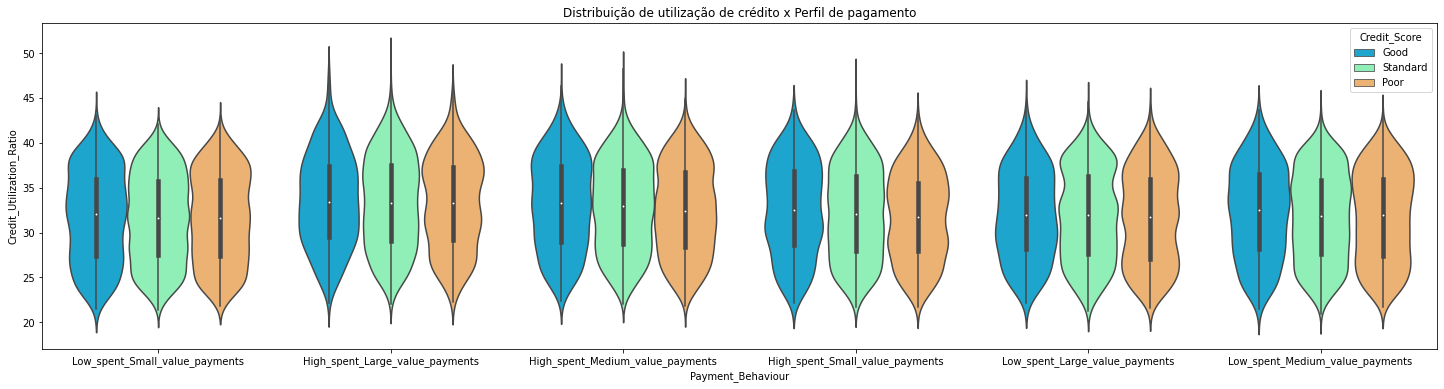

In [40]:
plt.figure(figsize=(25,6))
sns.violinplot(x='Payment_Behaviour',y='Credit_Utilization_Ratio',data=df_nonull_uniqueCID, hue='Credit_Score', palette='rainbow')
plt.title("Distribuição de utilização de crédito x Perfil de pagamento")
plt.show()

<Figure size 4248x72 with 0 Axes>

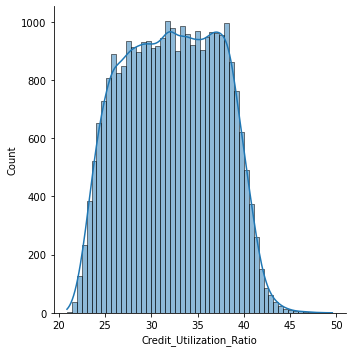

In [41]:
plt.figure(figsize=(59,1))
sns.displot(data=df_nonull_uniqueCID, x="Credit_Utilization_Ratio", kde=True)

<Figure size 12960x432 with 0 Axes>

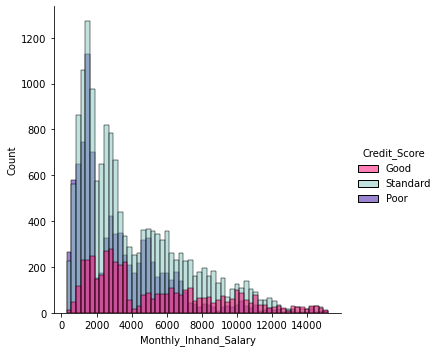

<Figure size 12960x432 with 0 Axes>

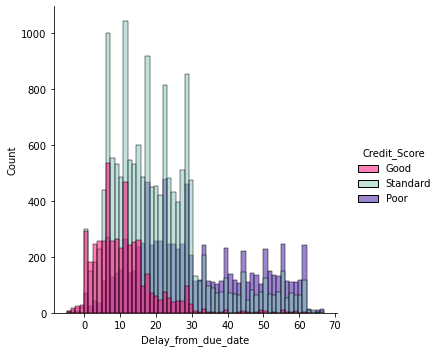

<Figure size 12960x432 with 0 Axes>

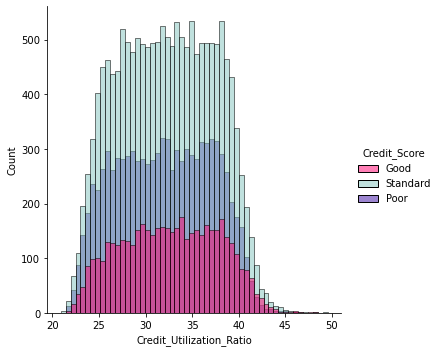

In [42]:
numCols = ['Monthly_Inhand_Salary', 'Delay_from_due_date', 'Credit_Utilization_Ratio']

for col in numCols:
    plt.figure(figsize=(180,6))
    sns.displot(x=col,data=df_nonull_uniqueCID, hue='Credit_Score', palette=["#ff006e", "#83c5be", "#3a0ca3"])
    plt.show()

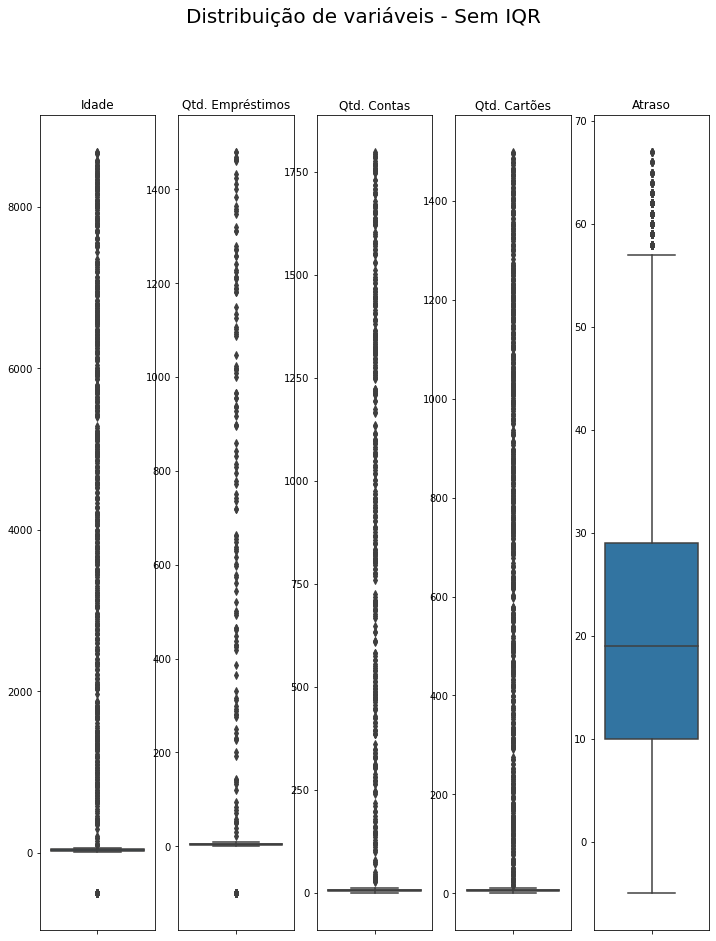

In [43]:
var_sem_iqr = df_nonull_uniqueCID.copy()

f, axes = plt.subplots(1, 5, figsize = (12, 15))
f.suptitle('Distribuição de variáveis - Sem IQR', size = 20)

# Age
sns.boxplot(ax=axes[0], data = var_sem_iqr, y = 'Age')
axes[0].set_title('Idade')
axes[0].set_ylabel('')

# Num_of_Loan
sns.boxplot(ax = axes[1], data = var_sem_iqr, y = 'Num_of_Loan')
axes[1].set_title('Qtd. Empréstimos')
axes[1].set_ylabel('')

# Num_Bank_Accounts
sns.boxplot(ax = axes[2], data = var_sem_iqr, y = 'Num_Bank_Accounts')
axes[2].set_title('Qtd. Contas')
axes[2].set_ylabel('')

# Num_Credit_Card
sns.boxplot(ax = axes[3], data = var_sem_iqr, y = 'Num_Credit_Card')
axes[3].set_title('Qtd. Cartões')
axes[3].set_ylabel('')

# Delay_from_due_date
sns.boxplot(ax = axes[4], data = var_sem_iqr, y = 'Delay_from_due_date')
axes[4].set_title('Atraso')
axes[4].set_ylabel('')

plt.show()


### Limpando outliers

* Idade - Clientes entre 18 e 100 anos;
* IQR

In [44]:
# aplicando IQR para as colunas Num_of_Loan, Num_Bank_Accounts, Num_Credit_Card, Delay_from_due_date
# a coluna age sera tratada limitando idades entre 0 e 100 anos

# age

df_nonull_uniqueCID = df_nonull_uniqueCID.copy()

print(df_nonull_uniqueCID.shape[0])

indice_age = df_nonull_uniqueCID[(df_nonull_uniqueCID['Age'] <= 18) | (df_nonull_uniqueCID['Age'] >= 100)].index

df_nonull_uniqueCID.drop(indice_age, inplace=True)

# Num of loan

q3, q1 = np.percentile(df_nonull_uniqueCID['Num_of_Loan'], [75, 25])

interquartil = q3 - q1

limsup = q3 + 1.5 * interquartil

df_nonull_uniqueCID = df_nonull_uniqueCID.drop(df_nonull_uniqueCID[(df_nonull_uniqueCID['Num_of_Loan'] > limsup) | (df_nonull_uniqueCID['Num_of_Loan'] <= 0)].index)

# Num_Bank_Accounts

q3, q1 = np.percentile(df_nonull_uniqueCID['Num_Bank_Accounts'], [75, 25])

interquartil = q3 - q1

limsup = q3 + 1.5 * interquartil

df_nonull_uniqueCID = df_nonull_uniqueCID.drop(df_nonull_uniqueCID[(df_nonull_uniqueCID['Num_Bank_Accounts'] > limsup) | (df_nonull_uniqueCID['Num_Bank_Accounts'] <= 0)].index)

# Num_Credit_Card

q3, q1 = np.percentile(df_nonull_uniqueCID['Num_Credit_Card'], [75, 25])

interquartil = q3 - q1

limsup = q3 + 1.5 * interquartil

df_nonull_uniqueCID = df_nonull_uniqueCID.drop(df_nonull_uniqueCID[(df_nonull_uniqueCID['Num_Credit_Card'] > limsup) | (df_nonull_uniqueCID['Num_Credit_Card'] <= 0)].index)

#Delay_from_due_date

q3, q1 = np.percentile(df_nonull_uniqueCID['Delay_from_due_date'], [75, 25])

interquartil = q3 - q1

limsup = q3 + 1.5 * interquartil

df_nonull_uniqueCID = df_nonull_uniqueCID.drop(df_nonull_uniqueCID[(df_nonull_uniqueCID['Delay_from_due_date'] > limsup) | (df_nonull_uniqueCID['Delay_from_due_date'] <= 0)].index)

df_nonull_uniqueCID.shape[0]

29664


21918

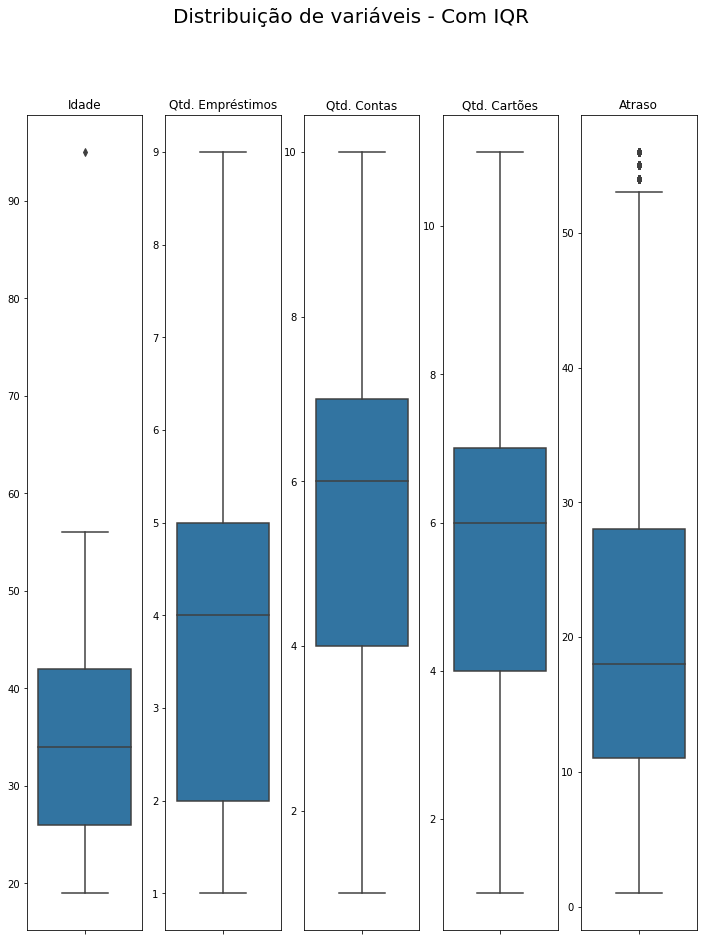

In [45]:
f, axes = plt.subplots(1, 5, figsize = (12, 15))
f.suptitle('Distribuição de variáveis - Com IQR', size = 20)

# Age
sns.boxplot(ax=axes[0], data = df_nonull_uniqueCID, y = 'Age')
axes[0].set_title('Idade')
axes[0].set_ylabel('')

# Num_of_Loan
sns.boxplot(ax = axes[1], data = df_nonull_uniqueCID, y = 'Num_of_Loan')
axes[1].set_title('Qtd. Empréstimos')
axes[1].set_ylabel('')

# Num_Bank_Accounts
sns.boxplot(ax = axes[2], data = df_nonull_uniqueCID, y = 'Num_Bank_Accounts')
axes[2].set_title('Qtd. Contas')
axes[2].set_ylabel('')

# Num_Credit_Card
sns.boxplot(ax = axes[3], data = df_nonull_uniqueCID, y = 'Num_Credit_Card')
axes[3].set_title('Qtd. Cartões')
axes[3].set_ylabel('')

# Delay_from_due_date
sns.boxplot(ax = axes[4], data = df_nonull_uniqueCID, y = 'Delay_from_due_date')
axes[4].set_title('Atraso')
axes[4].set_ylabel('')

plt.show()

### Pré-processamento (Drops vars. inúteis, Normalização, Encoding, Splits)

In [49]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

df_processado = df_nonull_uniqueCID.copy()
df_processado = df_processado.drop(['Customer_ID', 'Name', 'SSN', 'Type_of_Loan', 'Type_of_Loan_ajustado',
                                    'Credit_History_Age', 'Credit_Score', 'Month', 'Monthly_Balance',
                                    'Occupation', 'Payment_Behaviour'], axis=1)

#Pegando variáveis categóricas e numéricas

categorical = list(df_processado.select_dtypes(include=['object']).columns)  #Talvez criar no começo pra visualizaçao describe().transpose()
numerical = list(df_processado.select_dtypes(include=['int64', 'float64']).columns) #Talvez criar no começo pra visualizaçao describe()

# Dummy Encoder para variáveis categóricas

df_processado_categoricals = pd.DataFrame(columns = categorical, index = df_processado.index)
for col in df_processado.select_dtypes('object'):
    df_processado_categoricals[col], _ = df_processado[col].factorize()

#Scaling para variáveis numéricas

from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()

df_processado_numericals = pd.DataFrame(stdscaler.fit_transform(df_processado[numerical]), columns = numerical, index = df_processado_categoricals.index)

#Concatenando categóricas encodadas e numéricas escaladas

df_processado_final = pd.concat([df_processado_numericals, df_processado_categoricals], axis=1)

#Ordinal Encoder na target

from sklearn.preprocessing import OrdinalEncoder
ordenc = OrdinalEncoder()

df_processado_final['Credit_Score'] = ordenc.fit_transform(df_nonull_uniqueCID['Credit_Score'].values.reshape(-1,1)).astype(int)

#Definindo X e y

X = df_processado_final.drop(['Credit_Score'], axis = 1)
y = df_processado_final['Credit_Score']

X_todas_feats = df_nonull_uniqueCID.drop(['Customer_ID', 'Name', 'SSN', 'Type_of_Loan', 'Type_of_Loan_ajustado'], axis=1)
for col in X_todas_feats.select_dtypes('object'):
    X_todas_feats[col], _ = X_todas_feats[col].factorize()
    
for col in X_todas_feats.select_dtypes(['int64', 'float64']):
    X_todas_feats[col] = stdscaler.fit_transform(X_todas_feats[col].values.reshape(-1,1))

#Splitando o dataframe processado

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

X_train_todas_feats, X_test_todas_feats, y_train_todas_feats, y_test_todas_feats = train_test_split(X_todas_feats, y, test_size=0.2, stratify = y, random_state=42)

print('Shape dos splits com features seleciondadas (X_train, X_test, y_train, y_test): ')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('\nShape dos splits com todas as features ("): ')
print(X_train_todas_feats.shape, X_test_todas_feats.shape, y_train_todas_feats.shape, y_test_todas_feats.shape)

ModuleNotFoundError: No module named 'statsmodels.api'

In [ ]:
print('Encoding da target: ',{'0': ordenc.categories_[0][0],
       '1': ordenc.categories_[0][1],
       '2': ordenc.categories_[0][2]})

In [ ]:
df_processado_final.columns

In [ ]:
feat_imp = ['Outstanding_Debt','Delay_from_due_date','Changed_Credit_Limit','Credit_History_age',
            'Monthly_Inhand_Salary','Num_of_Delayed_Payment','Credit_Utilization_Ratio', 'Credit_Score']

sns.pairplot(df_processado_final[feat_imp], hue='Credit_Score', palette='viridis')

In [ ]:
def Distribution(columne,data,i):
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    font_dict = {'fontsize': 14}
    title=['Antes do processamento','Depois do processamento']
    ax = np.ravel(ax)
    if i==1:
        sns.set(style='whitegrid')
        sns.kdeplot(data=data,x=columne ,ax = ax[0],color='r').set_title(title[i])
        sns.boxplot(data=data,x=columne ,ax = ax[1],palette='magma').set_title(title[i])
    else:
        sns.set(style='whitegrid')
        sns.kdeplot(data=data,x=columne ,ax = ax[0],color='#2171b5').set_title(title[i])
        sns.boxplot(data=data,x=columne ,ax = ax[1],color='#2171b5').set_title(title[i])
        
    ax = np.reshape(ax, (1, 2))
    plt.tight_layout()

In [ ]:
Distribution(columne = 'Outstanding_Debt', data = df_nonull_uniqueCID, i = 0 )

In [ ]:
Distribution(columne = 'Outstanding_Debt', data = df_processado_final, i = 1 )

In [ ]:
sns.pairplot(df_processado_final,
             x_vars=['Monthly_Inhand_Salary','Outstanding_Debt'],
             y_vars=['Changed_Credit_Limit','Credit_Utilization_Ratio'])

### Seleção de Features e Feature Importance

In [ ]:
# Modelo Statsmodels para teste de hipótese e seleção de features

# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train)
non_reg_OLS = model.fit()
non_reg_OLS.summary()

In [ ]:
#VIF
def calc_vif(data):
    vif_df = pd.DataFrame(columns=['Var', 'VIF'])
    x_var_names = data.columns
    
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop(x_var_names[i])]
        r2 = sm.OLS(y, x).fit().rsquared
        vif = round(1/(1-r2),3)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by='VIF',axis = 0, ascending=False, inplace=False)

calc_vif(X_train)

In [ ]:
#ExtraTreeClassifier para feature_importances_

from sklearn.tree import ExtraTreeClassifier

xtc = ExtraTreeClassifier()
xtc.fit(X_train, y_train)
feat_importance = pd.Series(xtc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(20,8))
feat_importance.plot(kind='bar')

### -> PCA - Visualização e Feature Importance

In [ ]:
# Visualização da Análise de Componentes Principais (PCA)
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.axhline(0.7, ls='--', color='k')
plt.axvline(6, ls='--', color='k')
plt.text(7.4, 0.72, '70% da variância', fontsize=14)
plt.text(6.2, 0.43, '6 componentes', fontsize=14)
plt.title('Variância cumulativa explicada por número de componentes principais', size=18)
plt.show()

In [ ]:
print('Número de componentes principais para explicar pelo menos 70% da variância: {}'.format(np.argmax(pca.explained_variance_ratio_.cumsum() > 0.7)))
print(f'9 Componentes principais explicam:{pca.explained_variance_ratio_[:10].sum().round(4)*100}% da variância')

In [ ]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(X_train.columns) + 1)],
    index=X_train.columns
)

plt.figure(figsize=(24,14))
sns.heatmap(loadings.iloc[:,:7], annot=True, cmap='viridis')

In [ ]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

### Meme do homem-aranha apontando pro homem-aranha

<img src='img/meme-homem-aranha.JPG' width=30% height=40%>

##### - Inputação de Dados

In [ ]:
# escolher colunas para inputar e as formas de fazê-lo


### Modelagem

In [ ]:
# e ensembles (stacking de ExtraTreesClassifier com MLP)

In [ ]:
# Definindo fontes
font = {'family' : 'DejaVu Sans',
    'weight' : 'bold',
    'size'   : 30}

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, accuracy_score


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.dummy import DummyClassifier

from skopt import BayesSearchCV

In [ ]:
# Criando comparação de acurácia entre os 5 modelos escolhidos

comparacao_modelos = pd.DataFrame(columns = ['Modelo', 'Score'])

modelos = [LogisticRegression(solver='liblinear', random_state=42),
           KNeighborsClassifier(),
           DecisionTreeClassifier(random_state=42),
           RandomForestClassifier(random_state=42),
           XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
           ExtraTreeClassifier(random_state=42),
           MLPClassifier(solver='sgd', random_state=42),
           ]

for model in modelos:
    model_name = model.__class__.__name__
    scores = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'accuracy')
    comparacao_modelos.loc[len(comparacao_modelos)] = [model_name, scores.mean().round(4)]

comparacao_modelos

### Modelo Baseline: Dummy Classifier

In [ ]:
dummymodel = DummyClassifier(strategy='most_frequent')
dummymodel.fit(X_train, y_train)

y_pred_dummy = dummymodel.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_dummy))
cmp1 = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dummy))
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
cmp1.plot(ax=ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - Dummy Classifier', fontsize = 20)
plt.show()

In [ ]:
r_auc_dummy = roc_auc_score(y_test, dummymodel.predict_proba(X_test), multi_class = 'ovo')
print('Dummy Classifier tem AUROC = %.3f' % (r_auc_dummy))

### 1º Modelo: Extra Trees Classifier

In [ ]:
xtclf = ExtraTreesClassifier(n_jobs=-1)
xt_params = {'n_estimators':[2000],
                'criterion': ['gini'],
                'bootstrap':[True]
                }

bayessearch_xt = BayesSearchCV(xtclf,
                                  xt_params,
                                  cv=5,
                                  refit=['accuracy', 'f1'],
                                  n_jobs=-1,
                                  verbose=1,
                                  random_state=42
                                  ).fit(X_train, y_train)

y_pred_xt = bayessearch_xt.predict(X_test)
bayessearch_xt.best_params_

In [ ]:
print(classification_report(y_test, y_pred_xt))
cmp1 = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xt))
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
cmp1.plot(ax=ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - Extra Trees', fontsize = 20)
plt.show()

In [ ]:
r_auc_xt = roc_auc_score(y_test, bayessearch_xt.predict_proba(X_test), multi_class = 'ovo')
print('Extra Trees tem AUROC = %.3f' % (r_auc_xt))

### 2º Modelo: Random Forest

In [ ]:
rfclassifier = RandomForestClassifier(random_state = 42, n_jobs = -1)
rf_params = {'n_estimators': [500, 1500],
              'max_depth': [None],
              'criterion': ['gini']
               }

bayessearch_rf = BayesSearchCV(rfclassifier,
                               rf_params,
                               cv = 5,
                               scoring = 'accuracy',
                               n_jobs = -1,
                               verbose = 1,
                               refit = 'accuracy'
                               ).fit(X_train, y_train)

y_pred_rf = bayessearch_rf.predict(X_test)
bayessearch_rf.best_params_

In [ ]:
print(classification_report(y_test, y_pred_rf))
cmp1 = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf))
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
cmp1.plot(ax=ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - Random Forest', fontsize = 20)
plt.show()

In [ ]:
r_auc_rf = roc_auc_score(y_test, bayessearch_rf.predict_proba(X_test), multi_class = 'ovo')
print('Random Forest tem AUROC = %.3f' % (r_auc_rf))

### 3º Modelo: XGBoost

In [ ]:
xgbclassifier = XGBClassifier(eval_metric = 'logloss', use_label_encoder = False, random_state = 42)

xgb_params = {'n_estimators': [5, 750, 1500],
              'max_depth': [None],
              'gamma': [0.5, 1, 5],
              'subsample': [0.2, 1.0],
              'colsample_bytree': [0.6, 0.8],
              'min_child_weight': [0.3, 0.7, 1.0],
              'learning_rate': [0.1, 0.3]
               }

# OrderedDict([('colsample_bytree', 0.6),
#              ('gamma', 1.0),
#              ('learning_rate', 0.1),
#              ('max_depth', None),
#              ('min_child_weight', 0.7),
#              ('n_estimators', 1500),
#              ('subsample', 1.0)])

bayessearch_xgbc = BayesSearchCV(xgbclassifier,
                                 xgb_params,
                                 cv = 5,
                                 scoring = 'accuracy',
                                 refit = 'accuracy',
                                 verbose = 1,
                                 n_jobs = -1
                                 ).fit(X_train, y_train)

y_pred_xgbc = bayessearch_xgbc.predict(X_test)
bayessearch_xgbc.best_params_

In [ ]:
print(classification_report(y_test, y_pred_xgbc))
cmp1 = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgbc))
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
cmp1.plot(ax=ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - XGBoost', fontsize = 20)
plt.show()

In [ ]:
r_auc_xgbc = roc_auc_score(y_test, bayessearch_xgbc.predict_proba(X_test), multi_class = 'ovo')
print('XGBoost tem AUROC = %.3f' % (r_auc_xgbc))

#### Executando para todas as features e com dados crus (sem pré-processamento: normalização, encoders etc)

In [ ]:
xgb_todas_feats_params = {'n_estimators': [5, 1500],
                          'max_depth': [None],
                          'gamma': [2, 5],
                          'subsample': [0.2, 0.5, 0.8],
                          'colsample_bytree': [0.2, 0.6],
                          'min_child_weight': [0.6, 0.7, 1.0],
                          'learning_rate': [0.1, 0.2]
                          }

# OrderedDict([('colsample_bytree', 0.4306003275861896),
#              ('gamma', 4),
#              ('learning_rate', 0.10123700797206357),
#              ('max_depth', None),
#              ('min_child_weight', 0.7),
#              ('n_estimators', 281),
#              ('subsample', 0.5)])

bayessearch_xgbc_todas_feats = BayesSearchCV(xgbclassifier,
                                             xgb_todas_feats_params,
                                             cv = 5,
                                             scoring = 'accuracy',
                                             refit = 'f1',
                                             verbose = 1,
                                             n_jobs = -1
                                             ).fit(X_train_todas_feats, y_train_todas_feats)

y_pred_xgbc_todas_feats = bayessearch_xgbc_todas_feats.predict(X_test_todas_feats)
bayessearch_xgbc_todas_feats.best_params_

In [ ]:
print(classification_report(y_test_todas_feats, y_pred_xgbc_todas_feats))
cmp1 = ConfusionMatrixDisplay(confusion_matrix(y_test_todas_feats, y_pred_xgbc_todas_feats))
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
cmp1.plot(ax=ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - XGBoost c/ todas as Feats.', fontsize = 20)
plt.show()

In [ ]:
r_auc_xgbc_todas_feats = roc_auc_score(y_test_todas_feats, bayessearch_xgbc_todas_feats.predict_proba(X_test_todas_feats), multi_class = 'ovo')
print('XGBoost tem AUROC = %.3f' % (r_auc_xgbc_todas_feats))

### 4º Modelo: Multi-Layer Perceptron (Rede Neural SKLearn)

In [ ]:
mlpc = MLPClassifier(random_state = 42, max_iter = 500)

mlp_params = {'hidden_layer_sizes': [100, 200, 400],
              'activation': ['tanh'],
              'solver': ['sgd', 'adam'],
              'alpha': [0.001, 0.1, 0.3],
              'learning_rate': ['constant', 'invscaling']
              }

bayessearch_mlpc = BayesSearchCV(mlpc,
                                 mlp_params,
                                 cv = 3,
                                 scoring = 'accuracy',
                                 refit = 'accuracy',
                                 verbose = 1,
                                 n_jobs = -1
                                 ).fit(X_train, y_train)

y_pred_mlpc = bayessearch_mlpc.predict(X_test)
bayessearch_mlpc.best_params_

In [ ]:
print(classification_report(y_test, y_pred_mlpc))
cmp1 = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_mlpc))
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
cmp1.plot(ax=ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - Multi-Layer Perceptron', fontsize = 20)
plt.show()

In [ ]:
r_auc_mlp = roc_auc_score(y_test, bayessearch_mlpc.predict_proba(X_test), multi_class = 'ovo')
print('Dummy Classifier tem AUROC = %.3f' % (r_auc_mlp))

## Comparativos modelos

In [ ]:
#Extra Trees y_pred_xt
#Random Forest y_pred_rf
#XGBoost y_pred_xgbc / y_pred_xgbc_todas_feats
#Multi-Layer Perceptron y_pred_mlpc

In [ ]:
# et_fpr, et_tpr, _ = roc_curve(y_test, y_pred_xt) #Extra Trees
# rf_fpr, rf_tpr, _ = roc_curve(y_test, y_pred_rf) #Random Forest
# xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_pred_xgbc) #XGBoost
# xgbf_fpr, xgbf_tpr, _ = roc_curve(y_test_todas_feats, y_pred_xgbc_todas_feats) # XGBoost todas features
# mlp_fpr, mlp_tpr, _ = roc_curve(y_test, y_pred_mlpc) # Multi-Layer Perceptron

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
# plt.plot(et_fpr, et_tpr, linestyle='--', label='Reg Log (AUROC = %0.3f)' % r_auc)
# plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
# plt.plot(xgb_fpr, xgb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)
# plt.plot(xgbf_fpr, xgbf_tpr, marker='.', label='KNN (AUROC = %0.3f)' % knn_auc)
# plt.plot(mlp_fpr, mlp_tpr, marker='.', label='XGBoost (AUROC = %0.3f)' % xg_auc)

# Title
plt.title('ROC - Modelos', fontsize = 30)
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

### Comparativo Final de Métricas

In [ ]:
# comparativo_final_metricas = pd.DataFrame(columns = ['Acurácia', 'Recall', 'FN', 'F1-Score', 'AUROC'])

# comparativo_final_metricas.loc['Extra Trees'] = [metrics.accuracy_score(y_test, y_pred_xt).round(4),
#                                                     metrics.recall_score(y_test, y_pred_xt).round(4),
#                                                     metrics.confusion_matrix(y_test, y_pred_xt)[1][0],
#                                                     metrics.f1_score(y_test, y_pred_xt).round(4),
#                                                     r_auc.round(4)
#                                                     ]

# comparativo_final_metricas.loc['Random Forest'] = [metrics.accuracy_score(y_test, y_pred_rf).round(4),
#                                          metrics.recall_score(y_test, y_pred_rf).round(4),
#                                          metrics.confusion_matrix(y_test, y_pred_rf)[1][0],
#                                          metrics.f1_score(y_test, y_pred_rf).round(4),
#                                          knn_auc.round(4)
#                                          ]

# comparativo_final_metricas.loc['XGBoost'] = [metrics.accuracy_score(y_test, y_pred_xgbc).round(4),
#                                                           metrics.recall_score(y_test, y_pred_xgbc).round(4),
#                                                           metrics.confusion_matrix(y_test, y_pred_xgbc)[1][0],
#                                                           metrics.f1_score(y_test, y_pred_xgbc).round(4),
#                                                           nb_auc.round(4)
#                                                           ]

# comparativo_final_metricas.loc['XGBoost - All Feats.'] = [metrics.accuracy_score(y_test, y_pred_xgbc_todas_feats).round(4),
#                                                           metrics.recall_score(y_test, y_pred_xgbc_todas_feats).round(4),
#                                                           metrics.confusion_matrix(y_test, y_pred_xgbc_todas_feats)[1][0],
#                                                           metrics.f1_score(y_test, y_pred_xgbc_todas_feats).round(4),
#                                                           nb_auc.round(4)
#                                                           ]

# comparativo_final_metricas.loc['Multi Layer Perceptron'] = [metrics.accuracy_score(y_test, y_pred_mlpc).round(4),
#                                                    metrics.recall_score(y_test, y_pred_mlpc).round(4),
#                                                    metrics.confusion_matrix(y_test, y_pred_mlpc)[1][0],
#                                                    metrics.f1_score(y_test, y_pred_mlpc).round(4),
#                                                    rf_auc.round(4)
#                                                    ]


In [ ]:
# comparativo_final_metricas = comparativo_final_metricas.sort_values(by='Acurácia', ascending=False)
# comparativo_final_metricas

#### FIM